In [1]:
!pip install fastai

You should consider upgrading via the '/python/bin/python3 -m pip install --upgrade pip' command.


In [1]:
from fastai.data.all import *
from fastai.text.all import *
from torch.utils.data import DataLoader as TorchDataLoader
from fastai.callback.all import *
from fastai.torch_core import *

from readers.DrQA import data, model, module as reader_module
from readers.DrQA import config as cfg
from gensim.models import KeyedVectors
import importlib
import numpy as np
import pandas as pd

from fastaifix.learner import summary

from transformers import RobertaForSequenceClassification, RobertaModel, RobertaTokenizer, RobertaConfig
# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import AutoTokenizer

from textprocessor.normalization import VncorenlpTokenizer

In [2]:
importlib.reload(data)
importlib.reload(cfg)
importlib.reload(model)
importlib.reload(reader_module)

<module 'readers.DrQA.module' from '/code/readers/DrQA/module.py'>

In [3]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [4]:
seed_all(42)

In [5]:
args = cfg.Args()
args.weight_decay = 0.001
args.max_len = 200
args.hidden_size = 300
args.context_layers = 3
args.question_layers = 2
args.concat_rnn_layers = True
args.dropout_rnn = 0.2
args.dropout_emb = 0
args.layernorm_emb = True
args.dropout_rnn_output = True
args.embedding_dim = 300
args.num_features = 2


seed = 42
use_fp16 = False
bs = 32

In [5]:
print(args.dropout_rnn)
print(args.rnn_unit_type)
print(args.question_merge)
print(args.__dict__.items())

0.2
lstm
self_attn
dict_items([('model_type', 'rnn'), ('embedding_dim', 300), ('hidden_size', 300), ('context_layers', 3), ('question_layers', 2), ('rnn_unit_type', 'lstm'), ('concat_rnn_layers', True), ('question_merge', 'self_attn'), ('use_qemb', True), ('rnn_padding', True), ('fix_embeddings', True), ('optimizer', 'adamax'), ('learning_rate', 0.0001), ('momentum', 0), ('dropout_rnn', 0.2), ('dropout_rnn_output', True), ('grad_clipping', True), ('max_len', 150), ('num_features', 2), ('weight_decay', 0.001), ('dropout_emb', 0), ('layernorm_emb', True)])


In [32]:
# DATASET_PATH = 'Dataset'
# BATCH_SIZE = 32
# # max_seq_length = 256
# zltp = ZaloTextPreprocess()
# zltp.load_data(DATASET_PATH)
# train_df = zltp.train_df
train_df = pd.read_csv('dataset/qaset/train_feature_set2.csv')
valid_df = pd.read_csv('dataset/qaset/valid_feature_set2.csv')
# test_df = pd.read_csv('dataset/qaset/test_feature.csv')
train_df['is_valid'] = False
# test_df['is_valid'] = False # Do chia nhầm, gộp test này vào train
valid_df['is_valid'] = True


trainset = pd.concat([train_df, valid_df])
trainset.head(2)

,Unnamed: 0,id,title,label,q_toks,q_pos,q_ner,t_toks,t_pos,t_ner,is_valid
0,0,u5-1554707394_0,Vụ ném bom nguyên tử xuống Hiroshima và Nagasaki,True,Tên 2 quả bom_nguyên_tử Mỹ thả xuống Nhật_Bản năm 1945,N M N N Np V E Np N M,O O O O B-LOC O O B-LOC O O,"Vụ ném bom_nguyên_tử Hiroshima và Nagasaki là sự_kiện hai quả bom_nguyên_tử được Quân_đội Hoa_Kỳ , theo lệnh của Tổng_thống Harry_S_Truman , sử_dụng trong Chiến_tranh thế_giới lần thứ hai vào những ngày gần cuối của Chiến_tranh thế_giới thứ hai tại Nhật_Bản . Ngày 6 tháng 8 năm 1945 , quả bom_nguyên_tử thứ nhất mang tên "" Little_Boy "" đã được thả xuống thành_phố Hiroshima , Nhật_Bản . Sau đó 3 hôm , ngày 9 tháng 8 năm 1945 , quả bom thứ hai mang tên "" Fat_Man "" đã phát_nổ trên bầu_trời thành_phố Nagasaki .",N V N Np Cc Np V N M Nc N V N Np CH V N E N Np CH V E N N N N M E L N A N E N N N M E Np CH N M N M N M CH N N N M V N CH Np CH R V V E N Np CH Np CH E P M N CH N M N M N M CH Nc N N M V N CH Np CH R V E N N Np CH,O O O B-LOC O B-LOC O O O O O O O B-LOC O O O O O B-PER O O O O O O O O O O O O O O O O O O O B-LOC O O O O O O O O O O O O O O O O O O O O O B-LOC I-LOC O B-LOC O O O O O O O O O O O O O O O O O O O O O O O O O O B-LOC I-LOC O,False
1,1,u3-1557461233_1,Tiền Thái Bình hưng bảo,True,Niên_hiệu của Đinh_Tiên_Hoàng gọi là gì,N E Np V C P,O O B-PER O O O,"Khi lên làm vua , Đinh_Tiên_Hoàng đặt niên_hiệu là "" Thái_Bình "" và cho đúc tiền "" Thái_Bình hưng bảo "" bằng đồng . Đây là tiền duy_nhất được phát_hành trong thời nhà Đinh , vì cho_dù sau_này có sự thay_đổi ngôi vua trong họ Đinh nhưng không có sự thay_đổi niên_hiệu ( Đinh_Toàn lên kế_vị vẫn dùng niên_hiệu Thái_Bình ) .",N V V N CH Np V N V CH Np CH Cc E V N CH Np V V CH E N CH P V N A V V E N N Np CH E E N V N V N N E P Np C R V N V N CH Np V N R V N Np CH CH,O O O O O B-PER O O O O B-LOC O O O O O O B-LOC O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-PER O O O O O B-LOC O O,False


In [33]:
trainset['is_valid'].value_counts()

False    14487
True      3621
Name: is_valid, dtype: int64

In [34]:
ner_vocab = data.ReaderVocab.from_file('dataset/vocabs/train_feat_ner_vocab.txt')
pos_vocab = data.ReaderVocab.from_file('dataset/vocabs/train_feat_pos_vocab.txt')
ner_vocab.ind2tok

{0: '<unk>',
 1: '<pad>',
 2: '<cls>',
 3: 'o',
 4: 'b-per',
 5: 'b-org',
 6: 'i-org',
 7: 'b-loc',
 8: 'b-misc',
 9: 'i-misc',
 10: 'i-loc',
 11: 'i-per'}

In [35]:
wv_path = 'wordembedding/pretrain_models/word2vec/baomoi.window2.vn.model.bin'
wv = KeyedVectors.load_word2vec_format(wv_path,binary=True)
vocab = data.W2VVocab(['<unk>', '<pad>', '<cls>'], 0, 1, wv)

In [36]:
w_in_train = []
with open('dataset/vocabs/zlqa_token_list.txt', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        w_in_train.append(line.split(' ')[-1][:-1].lower())

# Data Prepair

## DataBlock

### Transform

In [37]:
class SimpleTokenizer(Transform):
    def __init__(self, vocab):
        self.vocab = vocab
        
    def tok2id(self, tokens):
#         if(len(tokens) < 100):
#             print(tokens)
#             print([self.vocab[tok] for tok in tokens])
        return tensor([self.vocab[tok.lower()] for tok in tokens], dtype=torch.int64)
    
    def ids2toks(self, ids):
        return ' '.join([self.vocab[ind] for ind in ids.tolist()])
        
    def encodes(self, x:str):
        t = TensorText(self.tok2id(x.lower().split()))
#         print('.', end='')
        return t
    
    def decodes(self, x):
        return TitledStr(self.ids2toks(x))
    
def simple_tokenize(items):
    return (L(doc) for doc in map(lambda x: x.split(),items))

In [38]:
def _is_tuple(o): return isinstance(o, tuple) and not hasattr(o, '_fields')
class CustomPad(DisplayedTransform):
    "Pad `samples` by adding padding by chunks of size `seq_len`"
    def __init__(self, max_avai_len, pad_idx=1, pad_first=False, seq_len=72,decode=True,**kwargs):
        store_attr('pad_idx, pad_first, seq_len,seq_len')
        self.max_avai_len = max_avai_len
        super().__init__(**kwargs)
    
    def _do_call(self, f, x, **kwargs):
        if not _is_tuple(x):
            if f is None: return x
            ret = f.returns_none(x) if hasattr(f,'returns_none') else None
            return retain_type(f(x, **kwargs), x, ret)
        if 'index' in kwargs:
            del kwargs['index']
        res = tuple(self._do_call(f, x_, index=i, **kwargs) for i, x_ in enumerate(x))
        return retain_type(res, x)
    
    def before_call(self, b):
        "Set `self.max_len` before encodes"
        self.max_len = [0 for i in b[0]]
        for xs in b:
            for i, x in enumerate(xs):
                if isinstance(x, TensorText):
                    self.max_len[i] = max(self.max_len[i], x.shape[0])
        self.max_len = [min(l, self.max_avai_len) for l in self.max_len]
        
    def __call__(self, b, **kwargs):
        self.before_call(b)
        return super().__call__(tuple(b), **kwargs)
    def encodes(self, x:TensorText, **kwargs):
        if(x.shape[0] >= self.max_avai_len):
            return x[:self.max_avai_len]
        else:
            return pad_chunk(x,pad_idx=self.pad_idx, pad_first=self.pad_first, seq_len=self.seq_len, pad_len=self.max_len[kwargs['index']])
    def decodes(self, o:TensorText, **kwargs):
        return o[o != self.pad_idx] if self.decode else o

class ConCat(DisplayedTransform):
    def before_call(self, b):
        "Set `self.max_len` before encodes"
        feat = torch.stack((b[1], b[2]), dim=2)
        b = L(b[0], feat, b[3], b[4])
        return b
    
    def before_decode(self, b):
        return L(b[0], b[1][0], b[1][1] , b[3], b[4])
        
    def decode  (self, x, **kwargs):
        b = self.before_decode(b)
        return super().decode(tuple(b), **kwargs)
    
    def __call__(self, b, **kwargs):
        b = self.before_call(b)
        return super().__call__(tuple(b), **kwargs)

### Transform Block

In [39]:
class CustomTextBlock(TransformBlock):
    "A `TransformBlock` for texts"
    def __init__(self, vocab, seq_len=72, **kwargs):
        type_tfms = [SimpleTokenizer(vocab)]
        return super().__init__(type_tfms=type_tfms,
                                dl_type=SortedDL,
                                dls_kwargs={'before_batch': CustomPad(args.max_len, seq_len=seq_len, pad_first=False)})

### DataBlock

In [40]:
# b1 = TextBlock.from_df('text')
b1 = CustomTextBlock(vocab)
b_ner = CustomTextBlock(ner_vocab)
b_pos = CustomTextBlock(pos_vocab)
get_x = [ColReader("t_toks"), ColReader("t_pos"), ColReader("t_ner"), ColReader("q_toks"), ColReader("q_pos"), ColReader("q_ner"), ]
blocks = [b1, b_pos, b_ner, b1, b_pos, b_ner, CategoryBlock(vocab=[False, True])]
dtb = DataBlock(blocks=blocks, get_x=get_x, get_y=ColReader('label'), splitter=ColSplitter(col='is_valid'), n_inp=6)


In [41]:
dls = dtb.dataloaders(trainset, path='.', bs=bs)

In [42]:
dls.show_batch()

<unk> là á_hậu <unk> hoa_hậu việt_nam <unk> số_đo ba vòng : <unk> chiều cao : <unk> cân nặng : <unk> tài_năng : múa đương_đại <unk> đêm chung_kết hoa_hậu việt_nam <unk> diễn ra vào ngày <unk> tại bãi biển đà_nẵng <unk> kết_quả chung_cuộc ngôi_vị quan_quân thuộc về hoa_hậu <unk> đến từ bạc_liêu <unk> á_hậu <unk> là dương_tú_anh đến từ hà_nội và á_hậu <unk> là <unk> cũng đến từ hà_nội <unk> khi tham_gia cuộc thi hoa_hậu việt_nam <unk> <unk> mới chỉ là sinh_viên năm thứ nhất khoa quản_lý văn_hoá trường đại_học văn_hoá hà_nội <unk> tuy chỉ có <unk> tuổi nhưng hoàng_anh đã sở_hữu rất nhiều kinh_nghiệm trên các sàn_diễn và được báo_chí dự_đoán sẽ dành ngôi_vị cao nhất trong cuộc thi <unk> chính vì_thế nên khi lọt top <unk> <unk> không phải là điều bất_ngờ đối_với hầu_hết các khán_giả <unk> sở_hữu một vẻ bề_ngoài xinh_xắn <unk> hiền_dịu cùng với những nét tính_cách
năm <unk> <unk> <unk> tiêu_diệt tây_sơn <unk> lên_ngôi hoàng_đế lập ra triều nguyễn và một lần nữa chọn huế làm kinh_đô cho triều

In [43]:
b = dls.one_batch()
print(b[0].type())
for i in b:
    print(i.size())

torch.cuda.LongTensor
(32, 150)
(32, 150)
(32, 150)
(32, 15)
(32, 15)
(32, 15)
(32,)


In [44]:
b[1].size()

(32, 150)

In [45]:
print(len(dls.train)*dls.bs)
print(len(dls.valid)*dls.bs)

14464
3648


# Model

In [46]:
from sklearn.metrics import roc_auc_score, f1_score
def auroc(inp, targ, axis=-1):
    inp, targ = inp.cpu().numpy()[:,1], targ.cpu().numpy()
    try:
        auc = roc_auc_score(targ, inp)
    except ValueError:
        auc = 0
    return auc

def f1(inp, targ, axis=-1):
    inp, targ = inp.cpu().numpy(), targ.cpu().numpy()
    inp = np.argmax(inp, axis=1)
    try:
        f1 = f1_score(targ, inp)
    except ValueError:
        f1 = 0
    return f1

In [47]:
# from .config import override_model_args
# from reader.reader import RnnDocReader, EmbeddingModule
import logging

class FastTextReader(nn.Module):
    def __init__(self, args, vocab, normalize=True):
        super(FastTextReader, self).__init__()
        self.args = args
        self.args.vocab_size = len(vocab)
        self.vocab = vocab
        
        self.embedding = reader_module.EmbeddingModule(args, vocab)
        # Building network. If normalize if false, scores are not normalized
        # 0-1 per paragraph (no softmax).
        if args.model_type == 'rnn':
            self.network = reader_module.RnnDocReader(args, normalize)
        else:
            raise RuntimeError('Unsupported model: %s' % args.model_type)
    
    def forward(self, x1, x1_f1, x1_f2, x2, x2_f1, x2_f2,):
        x1_mask = torch.ones_like(x1)
        x1_mask[x1 != 1] = 0
        x2_mask = torch.ones_like(x2)
        x2_mask[x2 != 1] = 0
        x1_emb = self.embedding(x1)
        x2_emb = self.embedding(x2)
        x1_emb = torch.cat((x1_emb, torch.stack((x1_f1, x1_f2), dim=2)), dim=2)
        x2_emb = torch.cat((x2_emb, torch.stack((x2_f1, x2_f2), dim=2)), dim=2)
        return F.softmax(self.network(x1_emb, x1_mask, x2_emb, x2_mask), dim = -1)

In [90]:
seed_all(seed)

In [91]:
model = FastTextReader(args, vocab, True)
criterion = CrossEntropyLossFlat(weight=tensor([0.3, 0.7]).cuda())

In [92]:
# !git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
# !cd Ranger-Deep-Learning-Optimizer && pip install -e . 

In [93]:
from transformers import AdamW
from functools import partial
from ranger import Ranger
# CustomAdamW = partial(AdamW, correct_bias=False)
# CustomAdamW = torch.optim.AdamW
# CustomAdamW.
# opt= partial(OptimWrapper,))

def opt(params, lr, **kwargs):
    return OptimWrapper(Ranger(params))

In [94]:
def splitter(model):
    return [{'params': [p for p in model.embedding.parameters()]},
        {'params': [p for p in model.network.parameters()]},]

In [13]:
learner = Learner(dls, model, loss_func=criterion, opt_func=opt, metrics=[accuracy, f1, auroc], splitter=splitter, cbs=CudaCallback,)
# Show graph of learner stats and metrics after each epoch.
learner.add_cbs(ShowGraphCallback())
learner.load('./models/2rd.pth')
# learner.data = dls

NameError: name 'dls' is not defined

In [96]:
print(learner.model)

FastTextReader(
  (embedding): EmbeddingModule(
    (embedding): Embedding(439057, 300, padding_idx=1)
    (layernorm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  )
  (network): RnnDocReader(
    (qemb_match): SeqAttnMatch(
      (linear): Linear(in_features=302, out_features=302, bias=True)
    )
    (context_rnn): CustomBRNN(
      (rnns): ModuleList(
        (0): BRNNBlock(
          (rnn): LSTM(604, 300, bidirectional=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (1): BRNNBlock(
          (rnn): LSTM(600, 300, bidirectional=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (2): BRNNBlock(
          (rnn): LSTM(600, 300, bidirectional=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (question_rnn): CustomBRNN(
      (rnns): ModuleList(
        (0): BRNNBlock(
          (rnn): LSTM(302, 300, bidirectional=True)
          (dropout): Drop

In [97]:
learner.freeze_to(1)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [98]:
summary(learner)

ValueError: too many values to unpack (expected 4)

In [ ]:
# learner = learner.to_fp16()

In [99]:
learner.save('untrain')

Path('models/untrain.pth')

In [73]:
learner.load('untrain')

set state called


In [100]:
learner.validate()

/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

(#4) [0.6936534643173218,0.6652858257293701,0.02663586225317201,0.4151572589810831]

set state called


SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.010964781977236271)

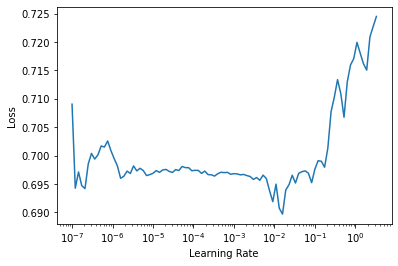

In [101]:
learner.lr_find()

In [62]:
# learner.fit_one_cycle(1, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,f1,auroc,time
0,0.675583,0.667582,0.591825,0.407892,0.537327,00:31


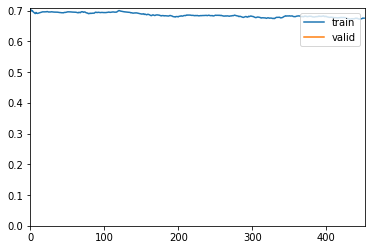

In [102]:
# Option khac
learner.fit_one_cycle(1,lr_max=5e-3,moms=(0.99,0.95, 0.99))

set state called


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=7.585775847473997e-07)

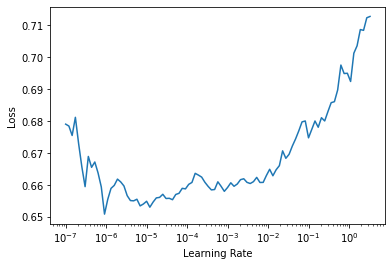

In [103]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,f1,auroc,time
0,0.659374,0.667578,0.590997,0.407465,0.537264,00:31


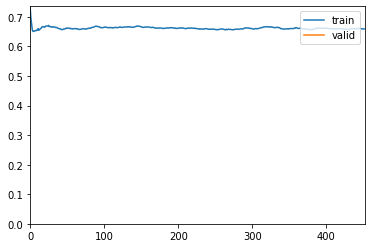

In [104]:
learner.fit_one_cycle(1,lr_max=2e-7,moms=(0.99,0.95, 0.99))

set state called


SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.2089296132326126)

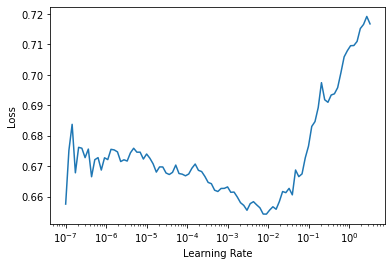

In [106]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,f1,auroc,time
0,0.662501,0.679655,0.508975,0.451011,0.526576,00:31
1,0.656570,0.656757,0.647887,0.377478,0.559897,00:31
2,0.646111,0.644479,0.647611,0.403503,0.575800,00:31
3,0.600182,0.647906,0.611433,0.438129,0.573672,00:31
4,0.560802,0.643939,0.631870,0.435849,0.577733,00:31


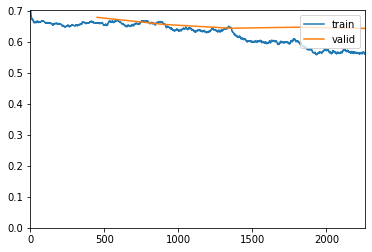

/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [107]:
learner.fit_one_cycle(5,lr_max=1e-3,moms=(0.99,0.95, 0.99))

set state called


SuggestedLRs(lr_min=3.6307807022240014e-06, lr_steep=5.754399353463668e-06)

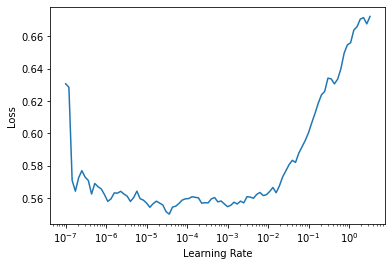

In [109]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,f1,auroc,time
0,0.562848,0.644095,0.632146,0.436590,0.577936,00:32
1,0.553357,0.643960,0.630765,0.433522,0.578168,00:31
2,0.557477,0.643870,0.630489,0.435738,0.578386,00:31
3,0.554863,0.644092,0.631593,0.435463,0.577655,00:31
4,0.551004,0.644074,0.631870,0.435983,0.577810,00:31


/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


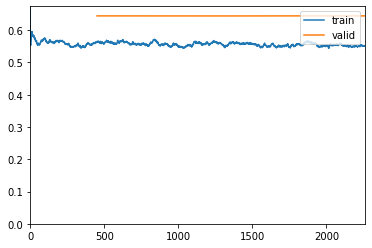

/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [110]:
learner.fit_one_cycle(5,lr_max=1e-5,moms=(0.99,0.95, 0.99))

In [105]:
learner.save('2rd')

Path('models/2rd.pth')

In [ ]:
learner.load('2rd')

epoch,train_loss,valid_loss,accuracy,f1,auroc,time
0,0.411804,0.401853,0.912771,0.850260,0.944224,00:13
1,0.487536,0.488596,0.777696,0.691667,0.891131,00:13
2,0.457522,0.410073,0.894001,0.829770,0.934793,00:14
3,0.400275,0.377638,0.934855,0.889572,0.951471,00:14
4,0.379050,0.372143,0.936695,0.892293,0.953579,00:14


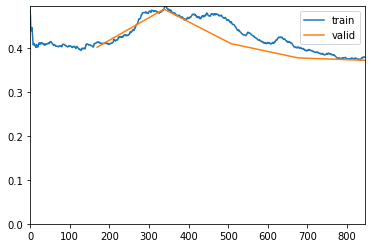

In [104]:
# Option khac
learner.fit_one_cycle(5,lr_max=1e-3,moms=(0.99,0.95, 0.99))

In [111]:
learner.recorder.plot()

AttributeError: 'Learner' object has no attribute 'plot'

In [65]:
learner.export('drqa02.pkl')

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
set state called


In [99]:
o,_ =learner.get_preds(ds_idx=1)
labels = np.argmax(o.cpu().numpy(), axis=1) == 1

In [88]:
print('tỉ lệ nhãn dự đoán là true')
print(np.sum(labels) / labels.shape[0])

tỉ lệ nhãn dự đoán là true
0.35112256164887745


In [58]:
orig_val = pd.read_csv('dataset/qaset/valid_set.csv')
results = pd.DataFrame({'Question': orig_val['question'], 'Text': orig_val['text'], 'Pred': labels,'True Label': orig_val['label']})

In [97]:
results.sample(frac=1).head(5)

,Question,Text,Pred,True Label
1928,Tỉnh Kon Tum có dãy núi nổi tiếng nào,Dãy núi Alpes maritimes là một dãy núi ở phía tây nam của dãy núi Alpes. Dãy núi này làm thành biên giới giữa tỉnh Alpes-Maritimes của Pháp và tỉnh Cuneo của Ý. Đèo Col de Tende chia cách dãy núi này với dãy núi Ligurian Alps; trong khi đèo Maddalena chia cách dãy núi này với dãy núi Cottian Alps. Vườn quốc gia Mercantour của Pháp nằm trong dãy núi này.,True,False
2649,chủ tịch ủy ban nhân dân hiện tại của tỉnh Gia Lai là người nào,"Tỉnh Gia Lai hiện có 4 nhà máy thuỷ điện lớn có công suất lớn hơn 100MW , gồm có Yali , Kanak-An Khê , Sêsan 3 , và Sêsan 4 .",False,False
1150,Iran nằm ở khu vực nào,"Cuộc Cách mạng năm 1979 dẫn tới việc thành lập nhà nước thần quyền "" Cộng hoà Hồi giáo Iran "" .",False,False
473,Thủ đô của Myanmar là gì,"So với các nước khu vực Đông Nam Á , Myanmar có giá mại dâm tương đối rẻ . Một khu đèn đỏ cũng xuất hiện ở Naypyidaw , thủ đô mới của Myanmar , với những nhà chứa ẩn mình trong các tiệm làm đẹp và các tiệm mát xa thu hút chủ yếu là doanh nhân và nhân viên quân sự .",True,True
1318,Vai trò của phù dâu và phù rể trong đám cưới,Em gái của cô là phù dâu trong đám cưới của cô với David Leepson trong năm 2012 của cô.,False,False


In [89]:
wrong = results.loc[results['Pred'] != results['True Label']]

In [90]:
wrong.head(5)

,Question,Text,Pred,True Label
1,Đơn vị tiền tệ của Thái Lan là gì,"Cho đến ngày 27 tháng 11 năm 1902, đồng tical đã được cố định trên một cơ sở bạc ròng, với 15 g bạc là 1 bạt. Điều này khiến cho giá trị đơn vị tiền tệ của Thái Lan dễ biến động so với các đồng tiền theo chế độ bản vị vàng. Năm 1857, giá trị của một số đồng tiền bạc nhất định đã được cố định theo quy định của pháp luật, với 1 bạt= 0,6 Straits dollar và 5 bạt = 7 rupee Ấn Độ. Trước năm 1880, tỷ giá hối đoái đã được cố định ở mức 8 bạt một Bảng Anh, song đã tụt xuống 10 bạt một bảng trong thập niên 1880.",False,True
25,Hoàng đế đầu tiên của Đại Việt từng chọn Huế làm kinh đô,"Từ thời các chúa Nguyễn, Huế đã từng được chọn làm thủ phủ xứ Đàng Trong: năm 1635-1687 Nguyễn Phúc Lan, Nguyễn Phúc Tần dựng phủ ở Kim Long; đến thời Nguyễn Phúc Thái, Nguyễn Phúc Khoát đã dời phủ về Phú Xuân trong những năm 1687-1712; 1739-1774. Đến thời Tây Sơn, Huế vẫn được vua Quang Trung chọn làm thành kinh đô cho vương quốc của ông. Năm 1802, khi Nguyễn Phúc Ánh lên ngôi hoàng đế, mở đầu cho vương triều Nguyễn kéo dài suốt 143 năm, một lần nữa lại chọn Huế làm nơi đóng đô.",False,True
38,Địa danh Mù Cang Chải thuộc tỉnh nào ở Việt Nam,"Khao Mang là một xã thuộc huyện Mù Cang Chải, tỉnh Yên Bái, Việt Nam.",False,True
45,vấn đề tranh chấp các đảo với các nước trong khu vực,"Chính phủ Malaysia theo chủ nghĩa thực dụng trong chính sách đối với các tranh chấp lãnh thổ, giải quyết các tranh chấp theo một số phương pháp, chẳng hạn như đưa vụ việc ra Tòa án Công lý Quốc tế. Nhiều quốc gia trong khu vực tranh chấp chủ quyền đối với quần đảo Trường Sa. Brunei và Malaysia vào năm 2008 tuyên bố kết thúc tuyên bố chủ quyền đối với các vùng đất của nhau, và giải quyết các vấn đề liên quan đến biên giới trên biển. Philippines có tuyên bố chủ quyền không thi hành đối với Sabah. Hoạt động cải tạo đất của Singapore gây ra căng thẳng giữa hai bên, và Malaysia cũng có tranh ch...",False,True
46,Châu Phi chiếm bao nhiêu phần trăm diện tích đất đai Trái Đất,"Châu Phi ( hay Phi châu ) là châu lục đứng thứ hai trên thế giới về dân số ( sau châu Á ) , thứ ba về diện tích ( sau châu Á và châu Mỹ ) . Với diện tích khoảng 30.221.532 km2 ( 11.668.599 mi2 ) bao gồm cả các đảo cận kề thì nó chiếm 20,4% tổng diện tích đất đai của Trái Đất .",False,True


In [84]:
len(wrong_idx)

241

In [83]:
results.sample(frac=1).head(10)

,Question,Text,Pred,True Label
2542,ai là giám đốc công an hiện tại của Hòa Bình,Hệ thống Ứng phó Tình trạng Khẩn cấp đã từng lộ diện để đối phó với Nạn diệt chủng Rwanda vào năm 1994 . Ngày 19 tháng 11 năm 2007 Giám đốc Đoàn Hoà bình là Ronald Tschetter đổi tên Đoàn Khủng hoảng thành Đoàn Hoà bình Ứng phó .,False,False
1215,Hươu cao cổ sống ở đâu nhiều nhất,"Các họ hàng hóa thạch gần nhất của chúng bao gồm họ Palaeomerycidae và họ Climacoceratidae trông tương tự như hươu, nhiều chi của họ thứ hai từng có thời được nhận dạng thành hươu cao cổ.",False,False
1889,Tỉnh Kon Tum có dãy núi nổi tiếng nào,"Bayankhongor có hai rặng núi chính, dãy núi Khangai ở phía bắc và dãy núi Altay ở khu vự trung tâm. Ikh Bogd là ngọn núi cao nhất trong tỉnh với 3957 mét, là một phần của dãy Altai và nằm tại sum Bogd.",True,False
2254,châu Á có bao nhiêu quốc gia và vùng lãnh thổ,"Đại hội Thể thao Trong nhà châu Á 2009 lần thứ 3 được tổ chức tại Hà Nội và một số địa phương khác của Việt Nam từ ngày 30 tháng 10 đến 8 tháng 11 năm 2009. Đại hội có 21 môn thi đấu, với 219 bộ huy chương để các vận động viên của 43 quốc gia và vùng lãnh thổ ở châu Á tranh tài.",False,False
429,Bà Nguyễn Thị Duệ đã dạy học ở đâu,"Phủ chúa Trịnh Cảm phục tài năng của bà, vua Mạc không những không trách tội mà còn phong làm Tinh phi. Sau khi nhà Mạc sụp đổ, bà được chúa Trịnh mời vào dạy học trong phủ chúa.",True,True
979,Sa mạc Sahara ở đâu,"Kiến bạc Sahara (Danh pháp khoa học: Cataglyphis bombycina) là một loài kiến trong họ Formicidae sống ở sa mạc Sahara. Chúng là một động vật sa mạc, cái nắng, cái nóng thiêu như đốt ở sa mạc không ảnh hướng tới chúng do chúng có cấu tạo đặc biệt.",False,False
806,Hội nghị Potsdam diễn ra vào ngày tháng năm nào,"Hội nghị Potsdam được tổ chức ở Cecilienhof, cung điện của thái tử Wilhelm Hohenzollern, tại Potsdam, Đức từ 16 tháng 7 đến 2 tháng 8 năm 1945. Các quốc gia tham dự hội nghị là Liên bang Xô Viết, Anh và Mỹ. Đại diện của ba quốc gia gồm có tổng bí thư đảng cộng sản Liên Xô Joseph Stalin, thủ tướng Anh Winston Churchill người sau đó được thay bởi Clement Attlee, và tổng thống Mỹ Harry S. Truman. Stalin, Churchill và Truman - cũng như Atlee, người thay thế Churchill làm thủ tướng Anh sau khi đảng Lao động giành chiến thắng trước đảng Bảo Thủ trong cuộc bầu cử năm 1945 - đã nhóm họp để thống n...",True,True
850,Trần Trinh Huy chết năm bao nhiêu,"Ông mất vào tháng 1 năm 1974 ở Sài Gòn và được đưa về an táng trong phần mộ gia đình tại ấp Cái Dầy , xã Châu Hưng , huyện Vĩnh Lợi , Bạc Liêu . Ba Huy mất sau khi hoang phí gần hết gia sản , chỉ để lại cho các con mấy căn phố lầu .",True,True
406,Hiện nay đã phát hiện bao nhiêu loại ung thư,"Hiện có khoảng 200 loại ung thư. Không phải tất cả các khối u là ung thư ngoài ra còn có khối u lành tính không lan sang các bộ phận khác của cơ thể. Có thể dấu hiệu và triệu chứng bao gồm một khối u, chảy máu bất thường, ho kéo dài, không giải thích được, giảm cân , và một sự thay đổi trong đại tiểu tiện. Hiện nay có khoảng hơn 100 bệnh ung thư.",True,True
1904,Trận đấu bóng đá quốc tế đầu tiên trên thế giới diễn ra vào năm bao nhiêu,"Cơ quan quản lý bóng đá thế giới , FIFA ( Fédération Internationale de Football Association , Liên đoàn bóng đá quốc tế ) được thành lập vào năm 1904 tại Paris với chủ tịch đầu tiên là ông Robert Guérin , một người Pháp , ngay từ khi thành lập FIFA đã tuyên bố sử dụng và tôn trọng bộ luật bóng đá do FA đưa ra .",True,False
